# Building Makemore


**References:**

1. [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo&t=3082s&ab_channel=AndrejKarpathy)

## Load the data

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-11-26 14:22:33--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2022-11-26 14:22:33 (57.3 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [ ]:
words = open("names.txt", "r").read().splitlines()

In [ ]:
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
len(words)

32033

In [ ]:
max(len(w) for w in words)

15

## Building a **Bigram** language model

In bigram models we look at a single character and wan't to predict the next one.

In [ ]:
b = {}
# Iterate over the words
for w in words:

    # Iterate over consecutive pairs of characters
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs[0:], chs[1:]):
        bigram = (ch1, ch2)
        # Keep track of how often each bigram accures
        b[bigram] = b.get(bigram, 0) + 1

In [ ]:
sorted(b.items(), key=lambda key_val: -key_val[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

Instead of keeping bigrams in a dictionary we'll store them in a tensor

In [ ]:
import torch

In [ ]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [ ]:
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [ ]:
itos = {idx: s for s, idx in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [ ]:
# Iterate over the words
for w in words:
    # Iterate over consecutive pairs of characters
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs[0:], chs[1:]):
        bigram = (ch1, ch2)
        # Keep track of how often each bigram accures
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]  
        N[idx1][idx2] += 1 

([], <a list of 0 Text major ticklabel objects>)

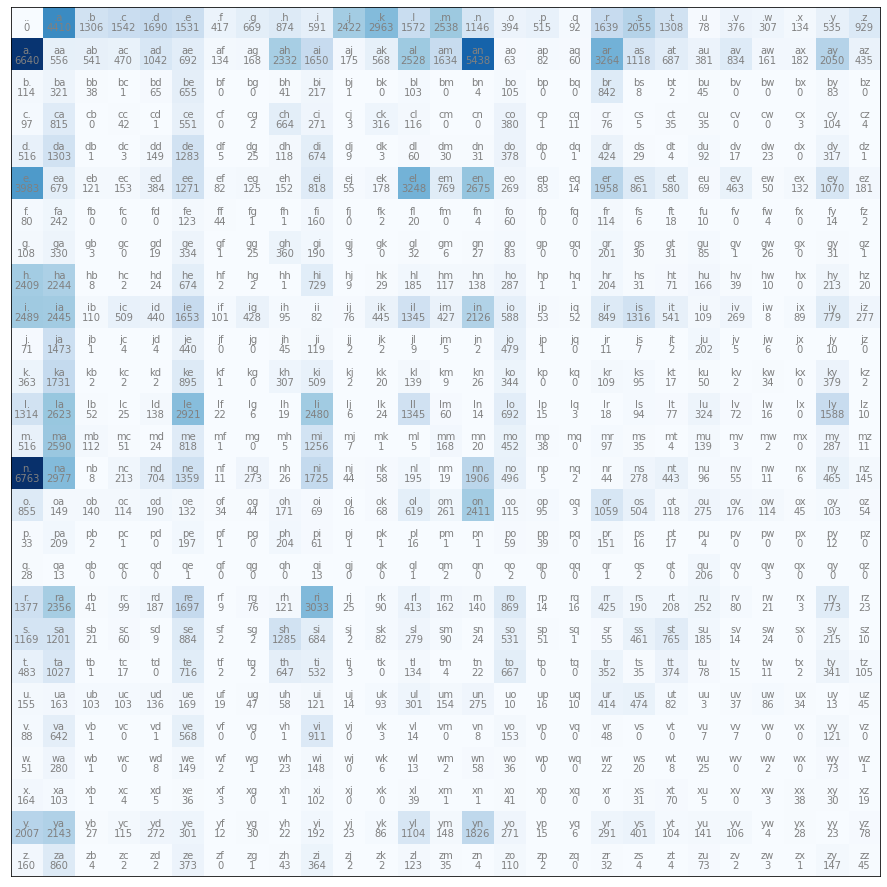

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")

plt.xticks([])
plt.yticks([])

We wan't to sample words from the bigram matrix according to their frequencies. Lets first take a look at `torch.multinomial()` sampler. 

In [ ]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [ ]:
# sample from p, multinomial just returns the index of the sample
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [ ]:
from collections import Counter


c = Counter(torch.multinomial(p, num_samples=20, replacement=True, generator=g).tolist())
c


Counter({0: 11, 2: 1, 1: 8})

Lets sample the start token from the bigram matrix.

In [ ]:
g = torch.Generator().manual_seed(2147483647)
p = N[0].float()
p = p / p.sum()
print(p)

idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


'm'

We can take a look at generated names using code bellow.

In [ ]:
sums = torch.sum(N, dim=1, keepdim=True) # this is a column vector
sums.shape

torch.Size([27, 1])

Note that broad casting happends only and only if one of the following is true

Align dimensions of the two tensors.

Starting from the right of tensor dimensions, we have to check if both of them have either:

1. same dimension
2. not same dimension, but one is 1
3. not same dimension, but one is undefined

In our case:

```
P:    27, 27
sums: 27,  1
```

this can be done.

In [ ]:
# Note that here the broad-casting of sums takes place
# before the element wise devision is performed.
P = (N.float() + 1) / sums

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    idx = 0
    generated_name = []

    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        generated_name.append(itos[idx])

        # if the end token
        if idx == 0:
            break

    print("generated_name: ", "".join(generated_name))

generated_name:  mor.
generated_name:  axx.
generated_name:  minaymoryles.
generated_name:  kondlaisah.
generated_name:  anchshizarie.
generated_name:  odaren.
generated_name:  iaddash.
generated_name:  h.
generated_name:  jhinatien.
generated_name:  egushl.


To convince ourself that the model is actually doing something, lets check against a baseline, lets make all characters equally likely to sample.

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    idx = 0
    generated_name = []

    while True:
        p = torch.ones(27)
        p = p / p.sum()

        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        generated_name.append(itos[idx])

        # if the end token
        if idx == 0:
            break

    print("generated_name: ", "".join(generated_name))

generated_name:  qvsaayxbqrqmyqwuznivanukotdjvdhd.
generated_name:  qnoymtzduqkatdetkpfjdgigvlejfkrsqlwnirghhzwlu.
generated_name:  idcx.
generated_name:  cekmzucjnjoeovjvrggqrjr.
generated_name:  cfbhabkslpokc.
generated_name:  xtxwbpmknuusxdgzfexhwqpldpdnwzvkyxsqjforqqpfxstwkfoufhvwfhmsuyyotvcvvqpfcbydjcouhkajkhqnnpqmmllaordqy.
generated_name:  gszpw.
generated_name:  zlgijinangzzuulsyvqrufuawavsdbnwvlmrypvgrsfgpshgnmwafqmsjdvbhngvoiigxhkwdltrdkwnagzyknqv.
generated_name:  lfstdqigvncdoidetsukgdp.
generated_name:  cfpjsxeqjcsmjwguzes.


**Log likelihood:**

$log(P(a) * P(b) * P(c))  = log(P(a)) + log(P(b)) + log(P(b))$


**Negative Log likelihood (often prefered):**

$log(P(a) * P(b) * P(c))  = - (log(P(a)) + log(P(b)) + log(P(b)))$



We can use the negative log likelihood as the loss function, i.e we should train a model which minimizes the negative log likelihood.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


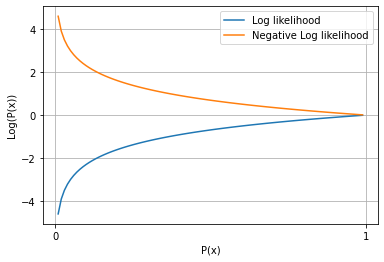

In [ ]:
import numpy as np

x = np.arange(0, 1, 0.01)
y = np.log(x)

plt.plot(x, y, label="Log likelihood")
plt.plot(x, -y, label="Negative Log likelihood")
plt.xticks(range(2))
plt.xlabel("P(x)")
plt.ylabel("Log(P(x))")
plt.grid()
plt.legend()

In [ ]:
log_likelihood = 0
n = 0

# Iterate over the words
for w in words:
    # Iterate over consecutive pairs of characters
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs[0:], chs[1:]):
        bigram = (ch1, ch2)
        # Keep track of how often each bigram accures
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        
        # Probability of a bigram.
        prob = P[idx1][idx2]
        log_prob = torch.log(prob)

        log_likelihood += log_prob.item() 

        # print(f"{ch1}{ch2}, prob: {prob:.4f}, log_prob: {log_prob:.4f}")

        n += 1

print(f"log_likelihood: {log_likelihood}")
print(f"negative log_likelihood (average): {-log_likelihood / n}")

log_likelihood: -559277.3065274358
negative log_likelihood (average): 2.451400885956518


We can evaluate how likely a word is.

In [ ]:
log_likelihood = 0
n = 0

# Iterate over the words
for w in ["matjaz"]:
    # Iterate over consecutive pairs of characters
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs[0:], chs[1:]):
        bigram = (ch1, ch2)
        # Keep track of how often each bigram accures
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        
        # Probability of a bigram.
        prob = P[idx1][idx2]
        log_prob = torch.log(prob)

        log_likelihood += log_prob.item() 

        print(f"{ch1}{ch2}, prob: {prob:.4f}, log_prob: {log_prob:.4f}")

        n += 1

print(f"log_likelihood: {log_likelihood}")
print(f"negative log_likelihood (average): {-log_likelihood / n}")

.m, prob: 0.0793, log_prob: -2.5350
ma, prob: 0.3901, log_prob: -0.9414
at, prob: 0.0203, log_prob: -3.8969
tj, prob: 0.0007, log_prob: -7.2389
ja, prob: 0.5083, log_prob: -0.6767
aj, prob: 0.0052, log_prob: -5.2602
jq, prob: 0.0003, log_prob: -7.9725
q., prob: 0.1066, log_prob: -2.2385
log_likelihood: -30.760107219219208
negative log_likelihood (average): 3.845013402402401


Migrating to a **Neural Network** approach

Create the training set of all the bigrams

X is a set of characters.
Y is a set of characters that should follow characters in X.

Example:
```
X = [0, 4, 4, ...]
Y = [1, 6, 7, ...]
```

This means that character 0 should be followed by a 1, character 4 should be followed by either 6 or 7. Our tasks is to train the model to predict the next character given the current character.

In [ ]:
def build_data_set(words, n_samples = 1):
    # create a training set of bigrams (x, y)
    x, y = [], []

    # Iterate over the words
    for w in words[0:n_samples]:
        # Iterate over consecutive pairs of characters
        chs = ["."] + list(w) + ["."]
        for ch1, ch2 in zip(chs[0:], chs[1:]):
            bigram = (ch1, ch2)
            # Keep track of how often each bigram accures
            idx1 = stoi[ch1]
            idx2 = stoi[ch2]  

            x.append(idx1)
            y.append(idx2)

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

In [ ]:
x, y = build_data_set(words, n_samples=1)

**How to feed x, y which are a set of integers to the neural network ?** We should one-hot encode them, also we have to make sure that the one-hot vectors are float and not integers!

In [ ]:
import torch.nn.functional as F

x_enc = F.one_hot(x, num_classes=27).float()
x_enc.shape

torch.Size([5, 27])

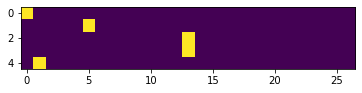

In [ ]:
plt.imshow(x_enc)
# plt.yticks(range(x_enc.shape[0]))
# plt.xticks(range(x_enc.shape[1]))

**Single neuron**

In [ ]:
w = torch.randn((27, 1))
x_enc @ w

tensor([[-0.6556],
        [-1.3190],
        [-1.0505],
        [-1.0505],
        [ 1.9967]])

**27 neurons**

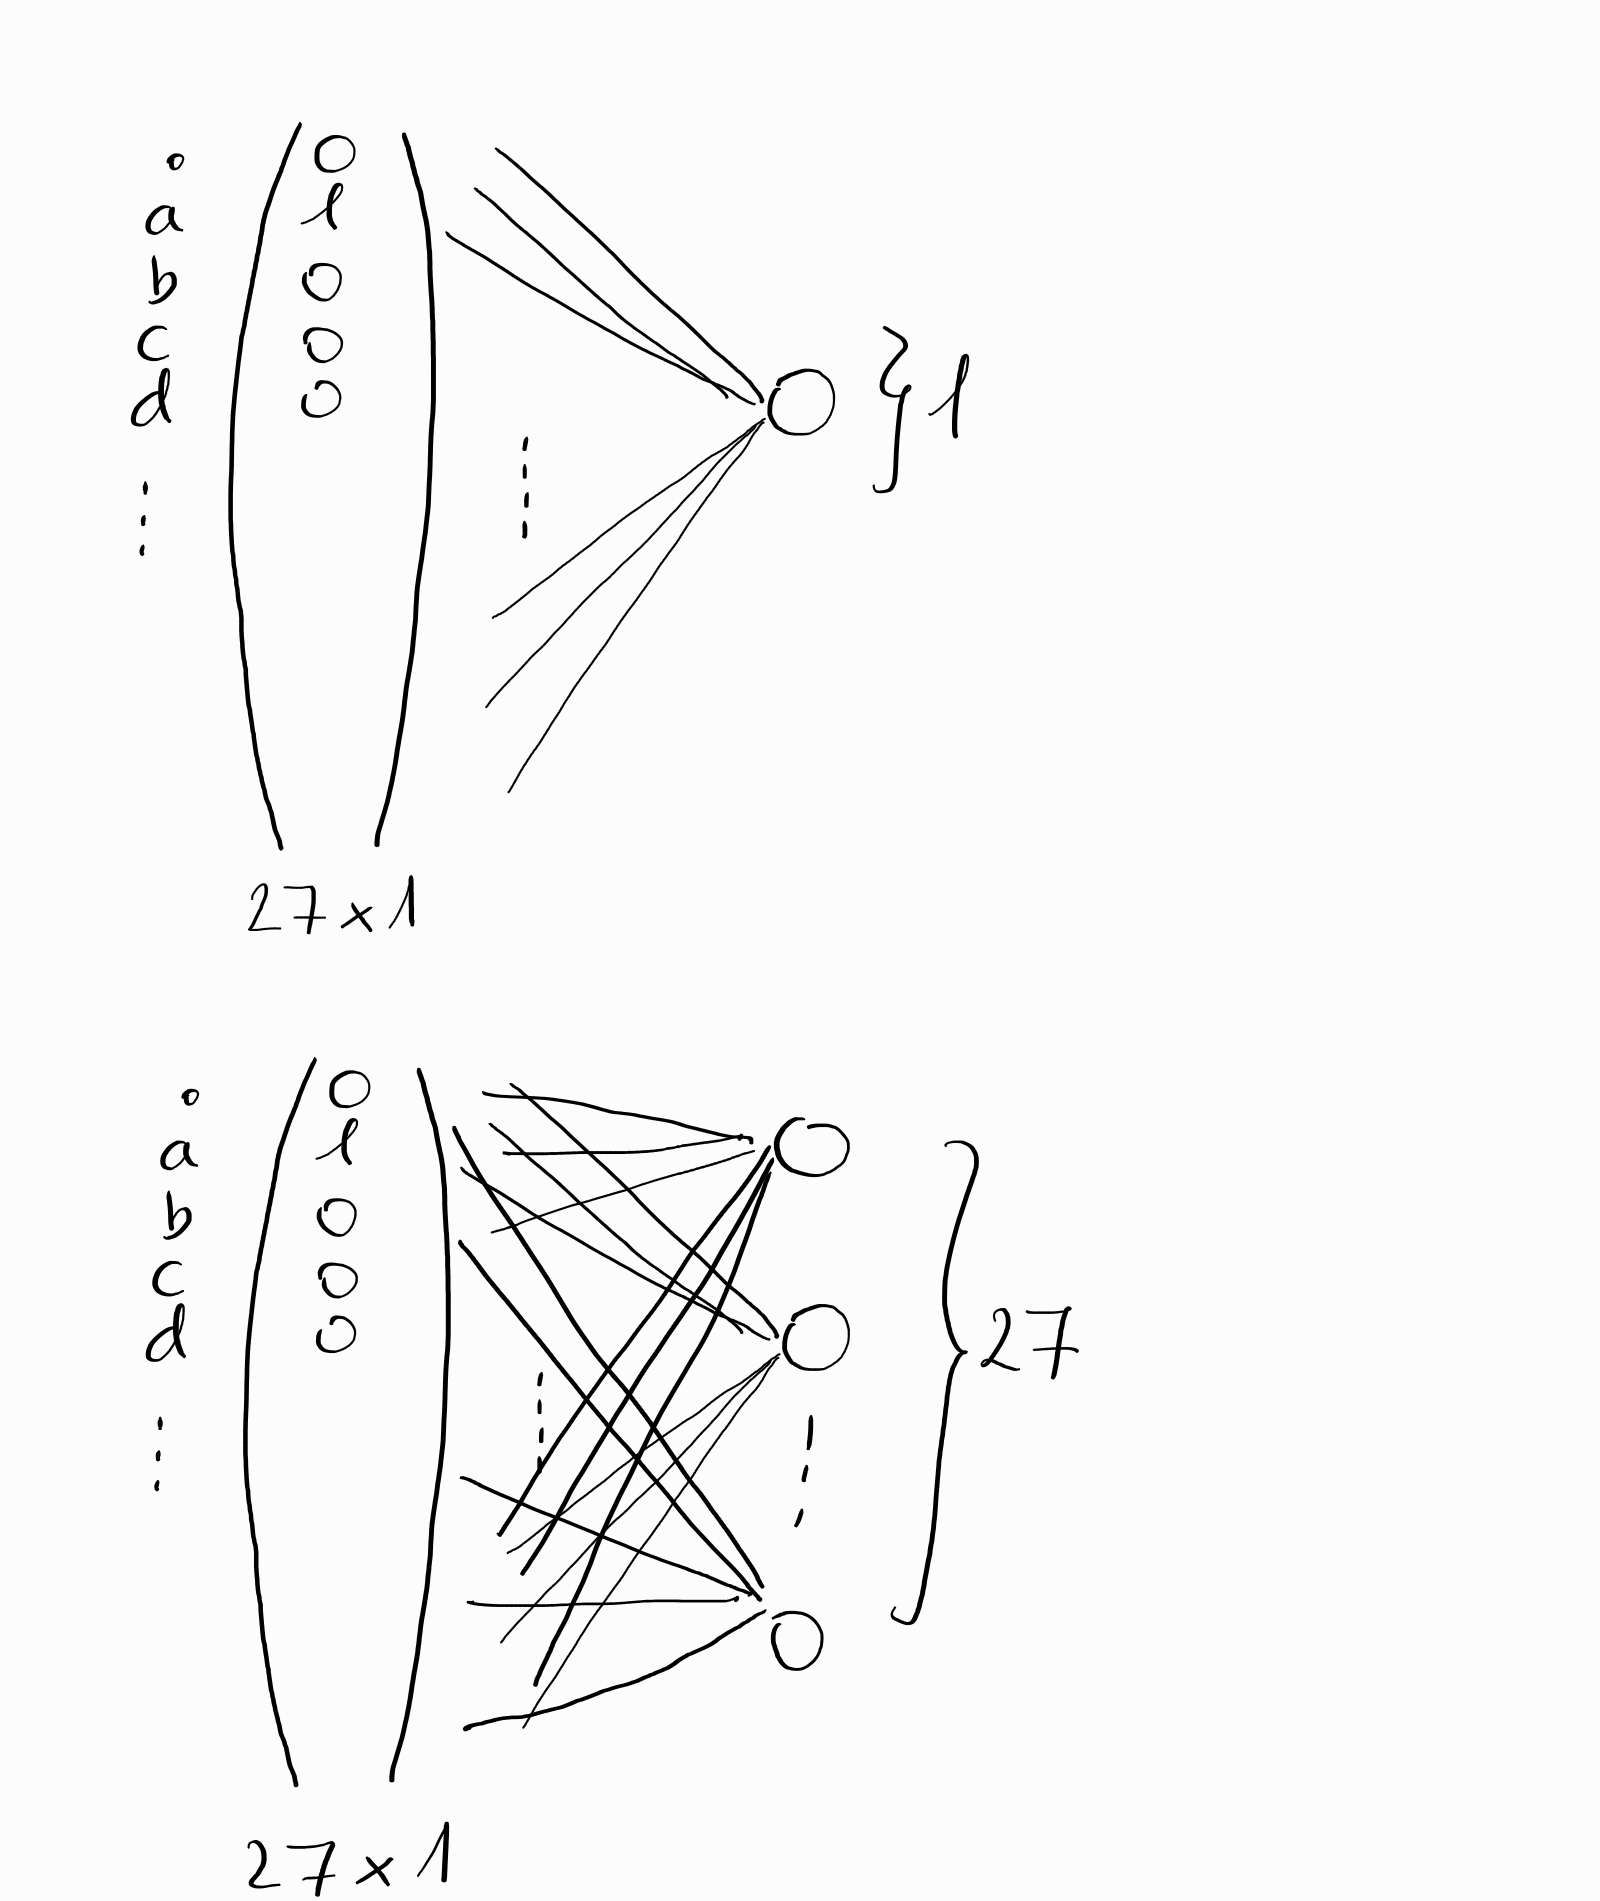

In [ ]:
w = torch.randn((27, 27))
x_enc @ w

tensor([[-0.2398, -0.0356, -1.2888, -0.1327, -0.7310,  0.4010,  0.1921, -0.3816,
         -1.2871, -1.6990,  0.6276,  0.7884, -0.0991,  0.6532, -2.1419, -1.6708,
          0.3796, -0.1066,  0.8512,  0.8616,  0.9112, -0.4853, -1.0550, -0.8459,
          0.2502,  0.6833, -0.9259],
        [ 0.1345, -0.8743, -2.1967, -0.3442, -1.6363,  1.1368, -0.1271, -1.2100,
         -1.4138, -0.0312,  0.0994, -0.7454,  0.5483,  0.5178, -0.1028, -0.3354,
          0.3258,  1.2043,  0.0605,  0.7843,  0.2142,  0.5228,  1.0686, -1.7755,
         -0.9203,  1.0725,  0.4035],
        [ 0.1073, -1.4846,  1.3731, -0.1222, -0.0664,  0.1078,  0.0494, -0.0720,
         -0.0597,  2.0177, -0.0789,  0.9712, -1.4917,  1.5108,  0.7724,  1.8635,
         -0.4935, -0.1613,  2.4262,  0.0490, -0.9495, -0.0648, -0.7151, -1.0204,
          1.0423, -1.9346,  0.2059],
        [ 0.1073, -1.4846,  1.3731, -0.1222, -0.0664,  0.1078,  0.0494, -0.0720,
         -0.0597,  2.0177, -0.0789,  0.9712, -1.4917,  1.5108,  0.7724,  1.8635

In [ ]:
# Fireing rate of the 13th neuron for the 3rd character (input)
(x_enc @ w)[3, 13] 

tensor(1.5108)

In [ ]:
(x_enc[3] * w[:, 13]).sum()

tensor(1.5108)

**Apply the softmax function to the outputs.**

If we apply the .exp() function to each output, we get something that acts as the count matrix which we previously had.

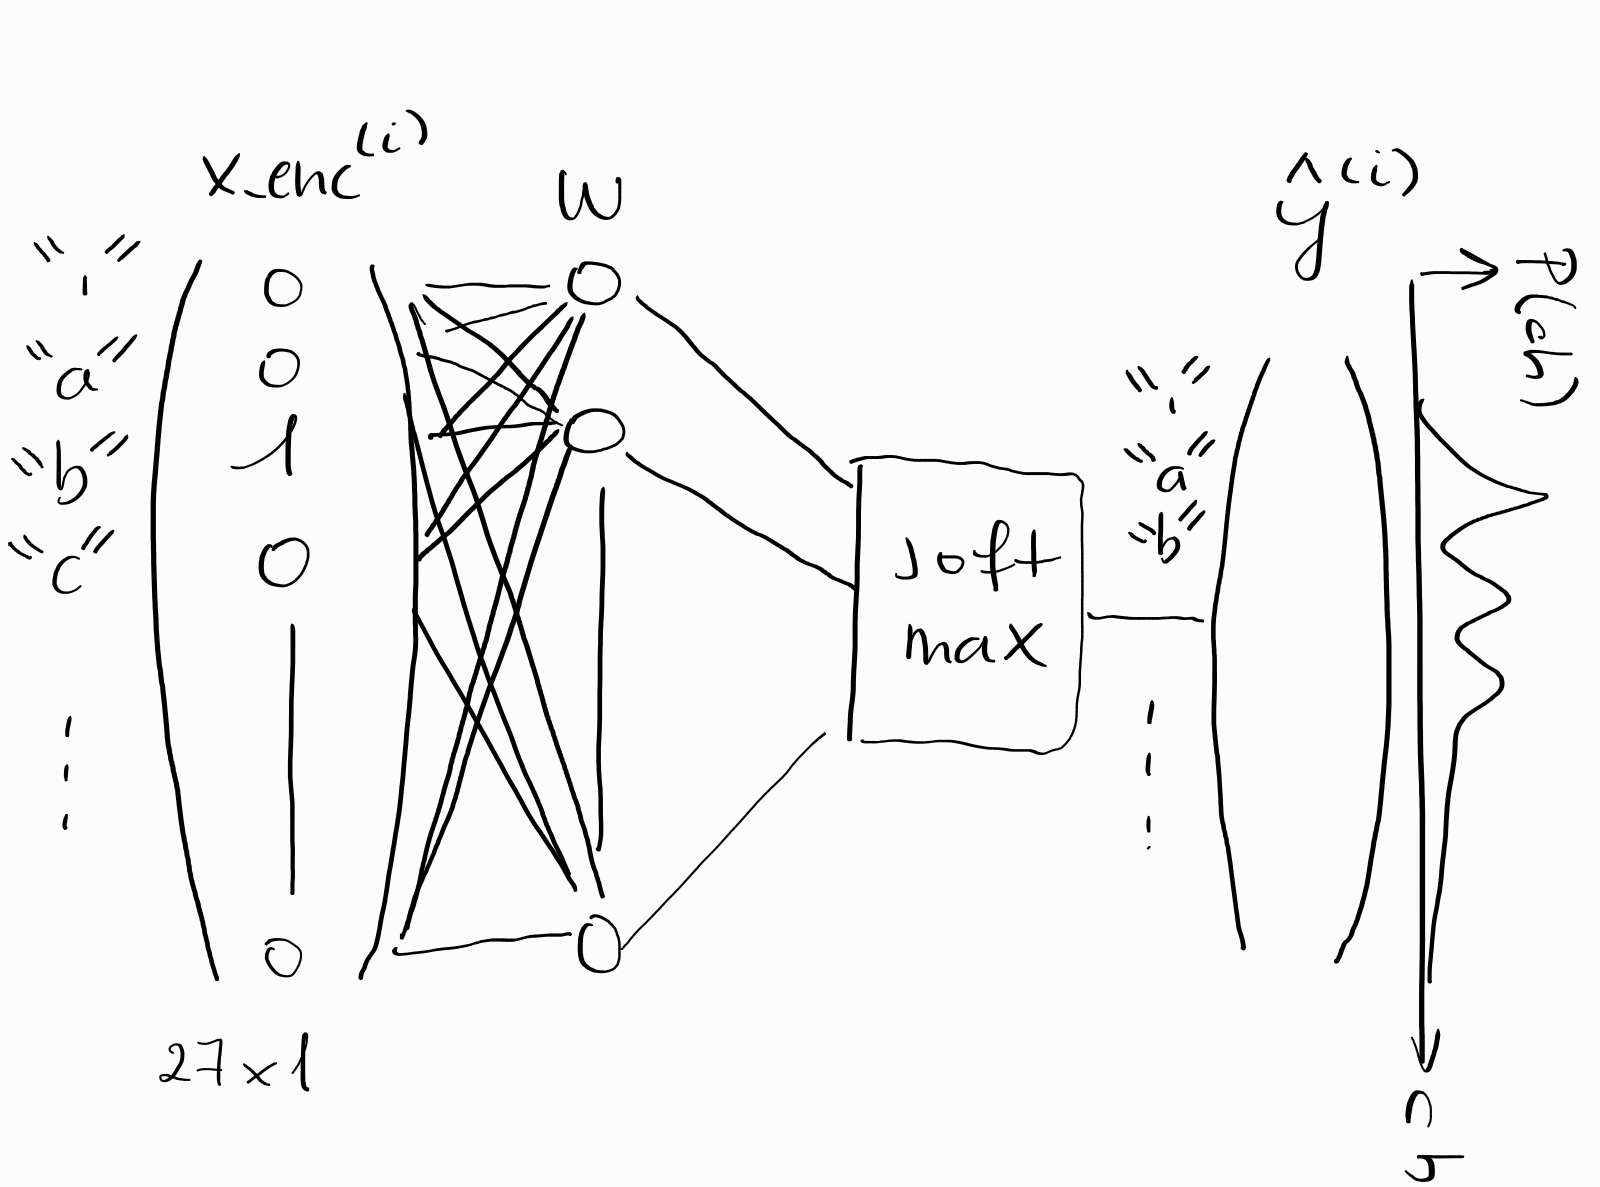

In [ ]:
# if you look closesly this is just the softmax function
log_counts = x_enc @ w
counts = log_counts.exp() # equvivalent to N
probs = counts / counts.sum(1, keepdims=True) 

**Visualize** the **input** (one-hot vector representing the specific character) and **output** (probability distribution over all possible characters) for the **first character in the training set x**.

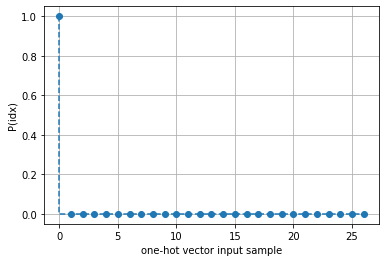

In [ ]:
plt.step(range(27), x_enc[0], "o--")
plt.xlabel("one-hot vector input sample")
plt.ylabel("P(idx)")
plt.grid()

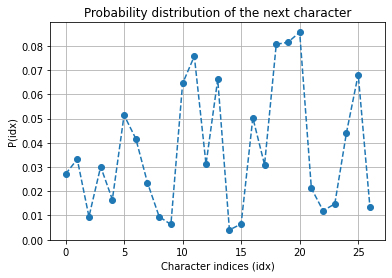

In [ ]:
plt.plot(range(27), probs[0], "o--")
plt.xlabel("Character indices (idx)")
plt.ylabel("P(idx)")
plt.title("Probability distribution of the next character")
plt.grid()

In [ ]:
nlls = torch.zeros(5)

for i in range(5):

    x_i = x[i].item()
    y_i = y[i].item()

    print(f"bigram: {itos[x_i]}{itos[y_i]}")
    print(f"Input to the neural network: {x_i}")
    print(f"Output (probability distribution over characters ) of neural network: {probs[i]}")
    print(f"Label (actual next character): {y_i}")

    print(f"Probability assigned by the neural net to the correct character: {probs[i][y_i]}")
    print(f"log likelihood: {torch.log(probs[i][y_i]).item()}")
    nll = -torch.log(probs[i][y_i]).item()
    print(f"negative log likelihood: {nll}")
    nlls[i] = nll

print(f"average negative log likelihood (Loss function): {nlls.mean().item()}")

bigram: .e
Input to the neural network: 0
Output (probability distribution over characters ) of neural network: tensor([0.0271, 0.0332, 0.0095, 0.0301, 0.0166, 0.0514, 0.0417, 0.0235, 0.0095,
        0.0063, 0.0645, 0.0757, 0.0312, 0.0662, 0.0040, 0.0065, 0.0503, 0.0309,
        0.0806, 0.0815, 0.0856, 0.0212, 0.0120, 0.0148, 0.0442, 0.0682, 0.0136])
Label (actual next character): 5
Probability assigned by the neural net to the correct character: 0.05140770599246025
log likelihood: -2.9679672718048096
negative log likelihood: 2.9679672718048096
bigram: em
Input to the neural network: 5
Output (probability distribution over characters ) of neural network: tensor([0.0342, 0.0125, 0.0033, 0.0212, 0.0058, 0.0931, 0.0263, 0.0089, 0.0073,
        0.0289, 0.0330, 0.0142, 0.0517, 0.0501, 0.0269, 0.0214, 0.0414, 0.0996,
        0.0317, 0.0654, 0.0370, 0.0504, 0.0869, 0.0051, 0.0119, 0.0873, 0.0447])
Label (actual next character): 13
Probability assigned by the neural net to the correct characte

**Training the (linear) network of 27 neurons**

In [ ]:
# Randomly initialize all 27 neurons

q = torch.Generator().manual_seed(2147483647)
w = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# Forward pass
x_enc = F.one_hot(x, num_classes=27).float()
logits = x_enc @ w # predict log-counts
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True) 

**Vectorized loss function.**

1. Get the probabilities that are assigned to the actual class.
2. Compute the negative log likelihood

In [ ]:
loss = -probs[torch.arange(5), y].log().mean()
loss

tensor(3.6172, grad_fn=<NegBackward0>)

**Backward pass**

After we run do a forward pass the computational graph is computed (since we passed **requires_grad=True** to the tensor. When we run `.backward()` the gradients are computed for each operation in the computational graph.

In [ ]:
# Set the gradients to zero
w.grad = None
loss.backward()

In [ ]:
w.grad

**Update the weights of the neural network**

In [ ]:
w.data = w.data -0.1 * w.grad

If we recalculate the forward pass we should get a lower loss

In [ ]:
# Forward pass
x_enc = F.one_hot(x, num_classes=27).float()
logits = x_enc @ w # predict log-counts
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True) 

loss = -probs[torch.arange(5), y].log().mean()
loss

tensor(3.5969, grad_fn=<NegBackward0>)

**Training loop**

In [ ]:
def build_data_set(words):
    # create a training set of bigrams (x, y)
    x, y = [], []

    # Iterate over the words
    for w in words:
        # Iterate over consecutive pairs of characters
        chs = ["."] + list(w) + ["."]
        for ch1, ch2 in zip(chs[0:], chs[1:]):
            bigram = (ch1, ch2)
            # Keep track of how often each bigram accures
            idx1 = stoi[ch1]
            idx2 = stoi[ch2]  

            x.append(idx1)
            y.append(idx2)

    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

In [ ]:
x, y = build_data_set(words)

In [ ]:
# Randomly initialize all 27 neurons

q = torch.Generator().manual_seed(2147483647)
w = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
N_ITERS = 100
losses = []
for k in range(N_ITERS):
    # Forward pass
    x_enc = F.one_hot(x, num_classes=27).float()
    logits = x_enc @ w # predict log-counts
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

    loss = -probs[torch.arange(x_enc.shape[0]), y].log().mean()
    losses.append(loss.data)
    print(loss.data)


    # Set the gradients to zero
    w.grad = None
    # Backward pass
    loss.backward()

    # Update the weights
    w.data = w.data -50 * w.grad

**Q: What value of the loss do we expect ?** We expect to get the negative log likelihood of around 2.4 as we did in the first approach where we calculated the frequency of bigrams !

[]

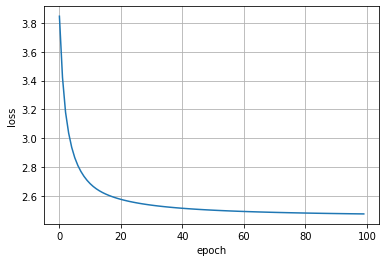

In [ ]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.plot()

To variy the claim we can plot the W (after training) matrix and compute the differences between W and P.

([], <a list of 0 Text major ticklabel objects>)

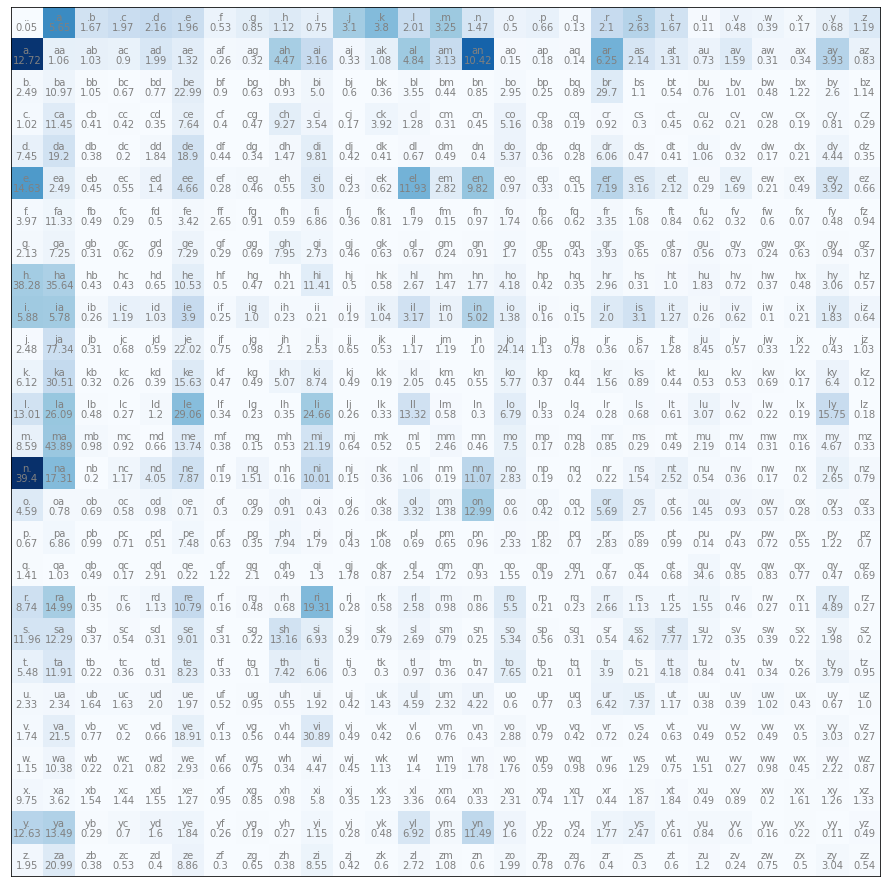

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, round(w[i, j].exp().item(), 2), ha="center", va="top", color="gray")

plt.xticks([])
plt.yticks([])

**Adding regularization**

In [ ]:
N_ITERS = 100
losses = []
for k in range(N_ITERS):
    # Forward pass
    x_enc = F.one_hot(x, num_classes=27).float()
    logits = x_enc @ w # predict log-counts
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

    loss = -probs[torch.arange(x_enc.shape[0]), y].log().mean() + 0.01 * (w ** 2).mean()
    losses.append(loss.data)
    print(loss.data)


    # Set the gradients to zero
    w.grad = None
    # Backward pass
    loss.backward()

    # Update the weights
    w.data = w.data -50 * w.grad

**Sampling from this model**

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    idx = 0
    generated_name = []

    while True:
        # Get the probability distribution of the next character.
        x_enc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = x_enc @ w
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        generated_name.append(itos[idx])

        # if the end token
        if idx == 0:
            break

    print("generated_name: ", "".join(generated_name))

generated_name:  mor.
generated_name:  axx.
generated_name:  minaymoryles.
generated_name:  kondmaisah.
generated_name:  anchthizarie.
generated_name:  odaren.
generated_name:  iaddash.
generated_name:  h.
generated_name:  jionatien.
generated_name:  egwulo.
